# Along-slope velocity
Model agnostic version in progress**

Calculating velocity tangent to the sloping gradient of bathymetry

Load modules

In [1]:
from pathlib import Path
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr

import xgcm
import cf_xarray

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj

By default retain metadata after operations. This can retain out of date metadata, so some caution is required

In [2]:
xr.set_options(keep_attrs=True);

Start a cluster with multiple cores

In [3]:
client = Client() 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38923/status,
Dashboard: /proxy/38923/status,Workers: 8
Total threads: 48,Total memory: 188.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38223,Workers: 8
Dashboard: /proxy/38923/status,Total threads: 48
Started: Just now,Total memory: 188.55 GiB
Comm: tcp://127.0.0.1:33793,Total threads: 6
Dashboard: /proxy/44723/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:38383,


### Load Data

Nominate a database from which to load the data and define an experiment

In [4]:
session = cc.database.create_session()
experiment = '01deg_jra55v13_ryf9091'

Limit to Southern Ocean and single RYF year

In [5]:
lat_slice  = slice(-80, -59)

start_time = '2086-01-01'
end_time   = '2086-12-31'

Load bathymetry data. Discard the geolon and geolat coordinates: these are 2D curvilinear coordinates that are only required when working above 65N

In [6]:
hu = cc.querying.getvar(experiment, 'hu', session, n=1).drop(['geolat_c', 'geolon_c']).sel(yu_ocean=lat_slice).load()

Load velocity data, limit to upper 500m and take the mean in time

In [7]:
u = cc.querying.getvar(experiment, 'u', session, ncfile="ocean.nc",
                       start_time=start_time, end_time=end_time,
                       chunks={}).sel(yu_ocean=lat_slice).sel(st_ocean=slice(0, 500)).mean('time')

v = cc.querying.getvar(experiment, 'v', session, ncfile="ocean.nc",
                       start_time=start_time, end_time=end_time,
                       chunks={}).sel(yu_ocean=lat_slice).sel(st_ocean=slice(0, 500)).mean('time')

Load model grid information directly from a grid data file

In [8]:
path_to_folder = Path('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/')
grid = xr.open_mfdataset(path_to_folder / 'ocean_grid.nc', combine='by_coords').drop(['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c'])

### Along-slope velocity

We calculate the along-slope velocity component by projecting the velocity field to the tangent vector, $u_{along} = \boldsymbol{u \cdot \hat{t}}$, and the cross-slope component by projecting to the normal vector, $v_{cross} = \boldsymbol{u \cdot \hat{n}}$. The schematic below defines the unit normal normal and tangent vectors for a given bathymetric contour, $\boldsymbol{n}$ and $\boldsymbol{t}$ respectively. 

![Sketch of topographic gradient](images/topographic_gradient_sketch.png)

Accordingly, the code below calculates the along-slope velocity component as

$$ u_{along} = (u,v) \boldsymbol{\cdot} \left(\frac{h_y}{|\nabla h|} , -\frac{h_x}{|\nabla h|}\right) = 
u \frac{h_y}{|\nabla h|} - v \frac{h_x}{|\nabla h|}, $$  

and similarly the cross-slope velocity component as

$$ v_{cross} = (u,v) \boldsymbol{\cdot} \left(\frac{h_x}{|\nabla h|} , \frac{h_y}{|\nabla h|}\right)  = 
u \frac{h_x}{|\nabla h|} + v \frac{h_y}{|\nabla h|}.$$ 


We need the derivatives of the bathymetry which we compute using the `xgcm` functionality.

In [9]:
# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')

# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

Calculate along-slope velocity component

In [10]:
# Along-slope velocity
u_along = u * dhu_dy / topographic_slope_magnitude - v * dhu_dx / topographic_slope_magnitude

# Load the data
u_along = u_along.load()
# warnings are for dividing by NaN/0, 
# i.e. when there is no topographic gradient and warning can be ignored

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

Vertical averaging (we only need this to plot the velocity on a map)

In [11]:
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(experiment, 'st_edges_ocean', session,
                                    start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': u.yu_ocean, 'xu_ocean': u.xu_ocean}, axis=[1, 2])

In [12]:
# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(experiment, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.sel(st_ocean=slice(0, 500))

# Depth average gives us the barotropic velocity
u_barotropic = (u_along * thickness).sum('st_ocean') / thickness.sum('st_ocean')

### Plotting

Create a circular path to clip plots

In [13]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

Create a land mask for plotting, set land cells to 1 and rest to NaN

In [14]:
land = xr.where(np.isnan(hu.rename('land')), 1, np.nan)

Set default fontsize

In [15]:
ft_size = 16
plt.rcParams.update({'font.size': ft_size})

#### Map of along-slope velocity with bathymetry contours

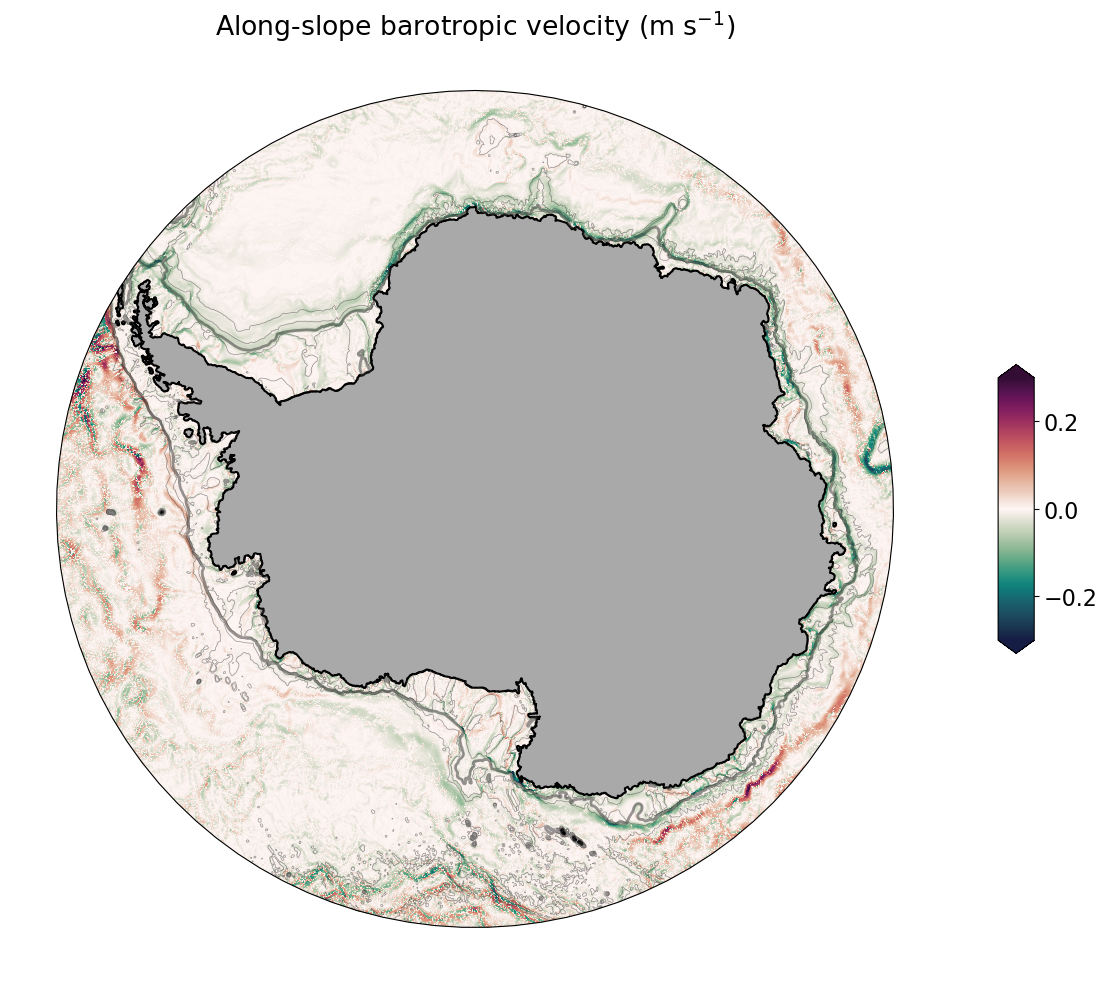

In [16]:
fig = plt.figure(1, figsize=(15, 15))

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(), facecolor="darkgrey")
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
land.plot.contourf(ax=ax, colors='darkgrey', zorder=2,
                   transform=ccrs.PlateCarree(), add_colorbar=False)

# Coastline
land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1],
                            transform=ccrs.PlateCarree(), add_colorbar=False)

# Depth contours
hu.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Along slope barotropic velocity
sc = u_barotropic.plot(ax = ax, cmap=cm.cm.curl,
                       transform=ccrs.PlateCarree(), vmin=-0.3, vmax=0.3,
                       cbar_kwargs={'orientation': 'vertical',
                                    'shrink': 0.25,
                                    'extend': 'both',
                                    'label': None,
                                    'aspect': 8})
  
ax.set_title('Along-slope barotropic velocity (m s$^{-1}$)');

In [18]:
client.close()